# Transformer Neural Network v2.0

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the data (replace the URL with the desired data source)
data = pd.read_csv('../Data/Savitzky-Golay Data/SVG_poly1.csv')
data["Year"] = pd.to_datetime(data["Year"])
data.set_index("Year", inplace=True)
data = data[::20]

# Normalize the data
scaler = MinMaxScaler()
data["Sunspot_Number"] = scaler.fit_transform(data[["Sunspot_Number"]]).reshape(-1,1)

# Create sequences for training
def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        x.append(data[i : i + seq_length])
        y.append(data[i + seq_length])

    return np.array(x), np.array(y)

seq_length = 60  # Adjust this value according to the desired sequence length
x, y = create_sequences(data["Sunspot_Number"].values, seq_length)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train = x_train.reshape(-1, seq_length, 1)
x_val = x_val.reshape(-1, seq_length, 1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
# Custom Transformer layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [
                Dense(dff, activation='relu'),
                Dense(d_model)
            ]
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [6]:
def build_transformer(d_model, num_heads, dff, input_shape, rate=0.1):
    inputs = Input(shape=input_shape)
    x = TransformerLayer(d_model, num_heads, dff, rate)(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Add this line to reshape the output
    x = Dense(1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# Define model parameters
d_model = 64
num_heads = 4
dff = 256
input_shape = (seq_length, 1)  # Replace seq_length with the desired sequence length

# Create the model
model = build_transformer(d_model, num_heads, dff, input_shape)
model.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')

In [7]:
epochs = 100
batch_size = 32

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
)


Epoch 1/100
92/92 [==============================] - 5s 38ms/step - loss: 0.0553 - val_loss: 0.0460
Epoch 2/100
92/92 [==============================] - 3s 34ms/step - loss: 0.0456 - val_loss: 0.0461
Epoch 3/100
92/92 [==============================] - 3s 35ms/step - loss: 0.0457 - val_loss: 0.0467
Epoch 4/100
92/92 [==============================] - 3s 35ms/step - loss: 0.0456 - val_loss: 0.0460
Epoch 5/100
92/92 [==============================] - 4s 39ms/step - loss: 0.0457 - val_loss: 0.0466
Epoch 6/100
92/92 [==============================] - 3s 36ms/step - loss: 0.0457 - val_loss: 0.0479
Epoch 7/100
92/92 [==============================] - 3s 36ms/step - loss: 0.0457 - val_loss: 0.0452
Epoch 8/100
92/92 [==============================] - 3s 37ms/step - loss: 0.0458 - val_loss: 0.0463
Epoch 9/100
92/92 [==============================] - 3s 36ms/step - loss: 0.0457 - val_loss: 0.0461
Epoch 10/100
92/92 [==============================] - 4s 41ms/step - loss: 0.0456 - val_loss: 0.0467

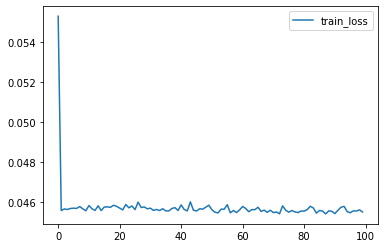

23/23 [==============================] - 1s 14ms/step
RMSE: 50.4292937207941


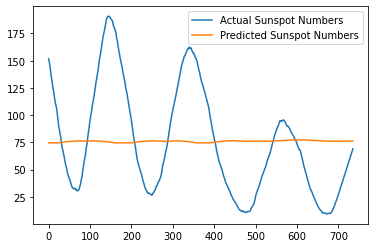

In [8]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

# Make predictions
x_test = x_val  # Replace x_val with your actual test data if available
y_pred = model.predict(x_test)

# Inverse scale the predictions
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the model's performance (e.g., using RMSE)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val.reshape(-1,1)), y_pred))
print("RMSE:", rmse)

# Plot the predictions
plt.plot(scaler.inverse_transform(y_val.reshape(-1,1)), label='Actual Sunspot Numbers')
plt.plot(y_pred, label='Predicted Sunspot Numbers')
plt.legend()
plt.show()